In [1]:
# Whether to work with single or double precision when using JAX 
# Double precision is strongly recommended
# but as of Nov 2023 double precision is not supported on Apple silicon
#
%env JAX_ENABLE_X64=True
#
import numpy  as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
#
from sht.sht import DirectSHT
#
%load_ext autoreload
%autoreload 2

env: JAX_ENABLE_X64=True


In [2]:
# We can very quickly calculate Ylm values. As an example, compute them up to lmax=Nl
Nl = 500
Nx = 1000
#
sht= DirectSHT(Nl,Nx)

In [3]:
# Put a sequence of points on the equator
phis   = np.linspace(0,2*np.pi,10)
thetas = np.ones_like(phis)*np.pi/2
wts    = np.ones_like(phis)
#
# And some along the meridian -- avoiding high |x|.
new_thetas = (np.arange(6)+1.5)/8. * np.pi
thetas = np.append(thetas,new_thetas)
phis   = np.append(phis,np.zeros_like(new_thetas))
wts    = np.append(wts,np.ones_like(new_thetas))

In [4]:
alms = sht(thetas,phis,wts)

Sorting & digitizing took  0.39778590202331543  seconds.
Reshaping took  0.3267710208892822  seconds.
Precomputing vs took  0.5307102203369141  seconds.
Computing alm's took  1.1998412609100342  seconds.
Sorting & digitizing took  0.39732789993286133  seconds.
Reshaping took  0.3259758949279785  seconds.
Precomputing vs took  0.4592738151550293  seconds.
Computing alm's took  0.989304780960083  seconds.


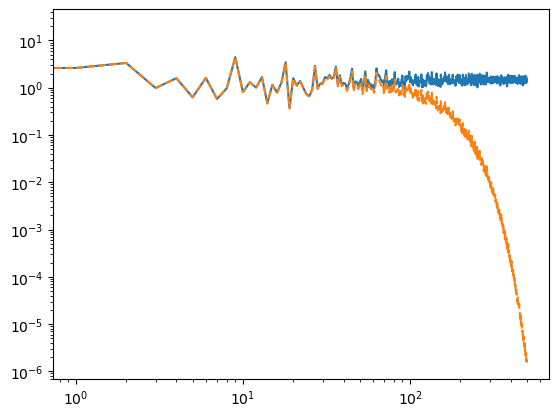

In [5]:
# Let's convolve the alms with a beam 
alms_smooth = hp.sphtfunc.smoothalm(alms,fwhm=np.pi/180,pol=False,inplace=False)
plt.loglog(hp.alm2cl(alms))
plt.loglog(hp.alm2cl(alms_smooth), ls='--')

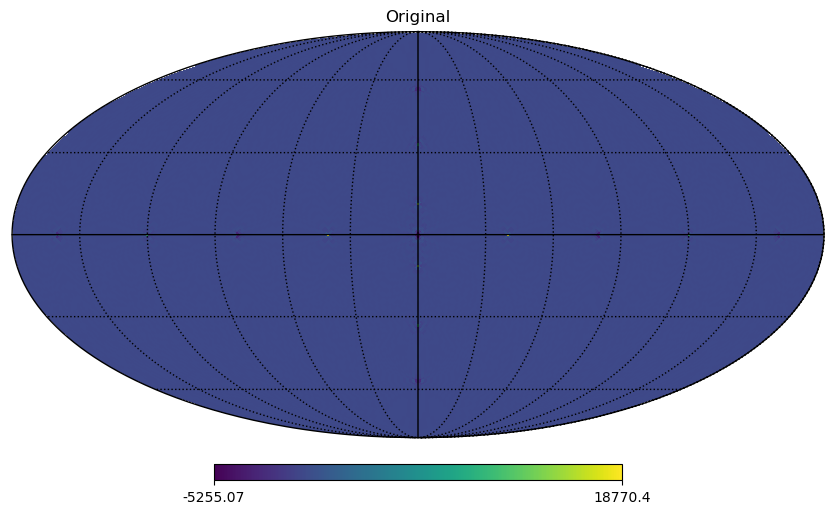

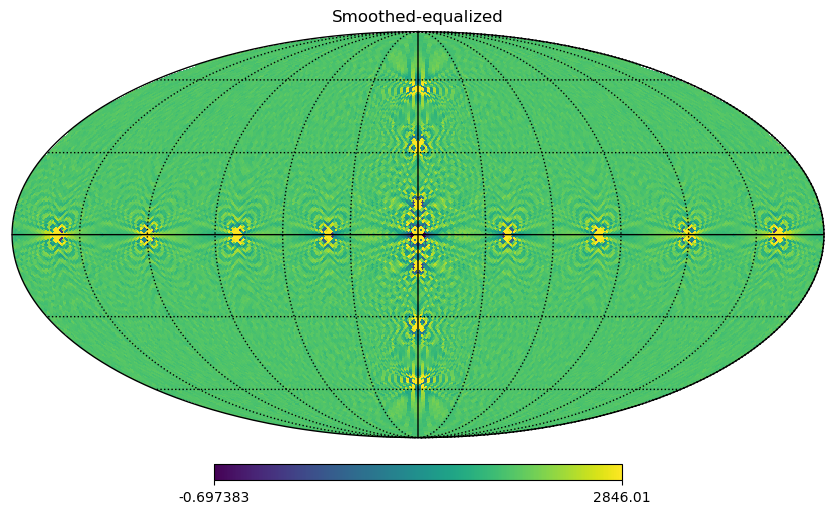

In [6]:
nside = 64
#
hp.mollview(hp.alm2map(alms, nside), title='Original')
hp.graticule()
plt.show()
hp.mollview(hp.alm2map(alms_smooth, nside),norm='hist', title='Smoothed-equalized')
hp.graticule()
plt.show()

It's hard to see th point sources in this map. Let's project around the source location

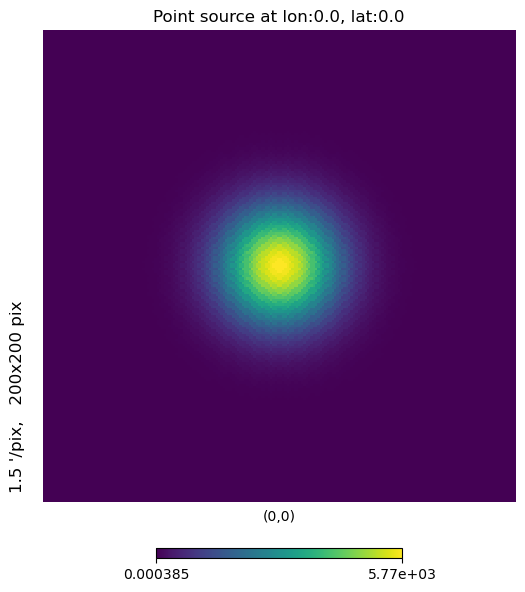

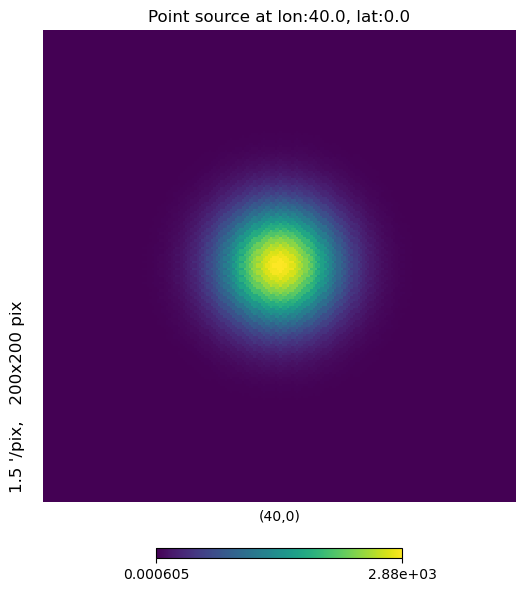

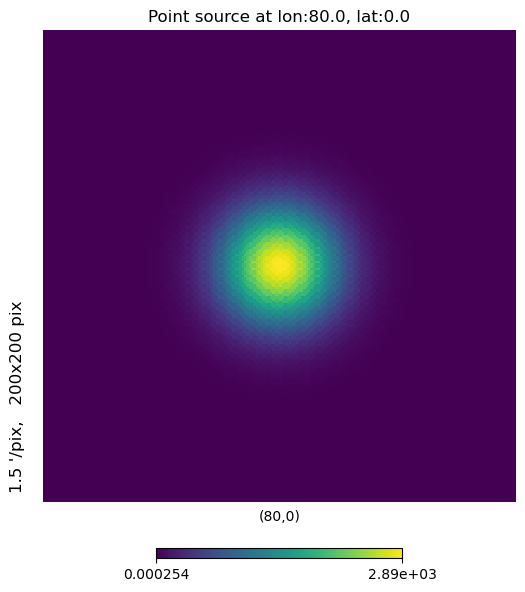

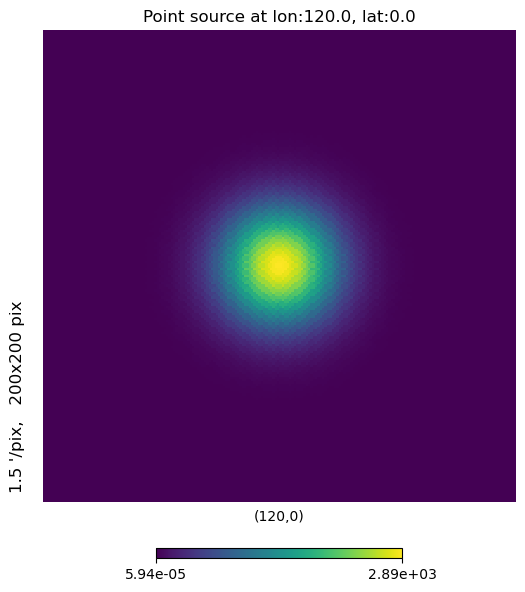

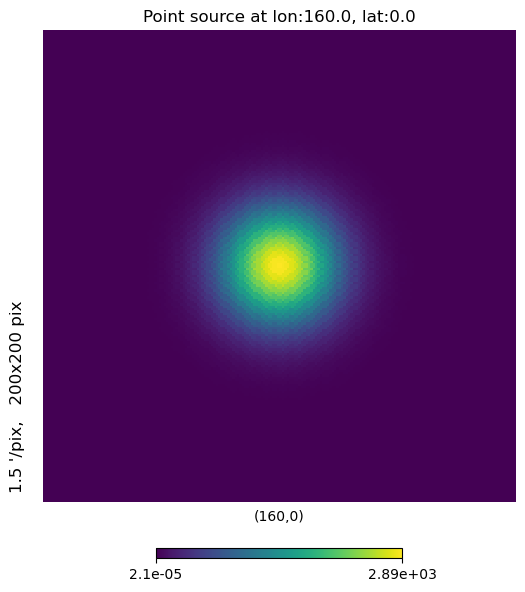

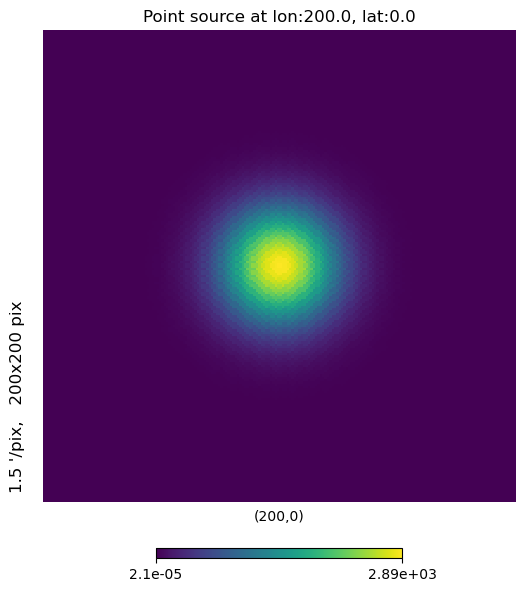

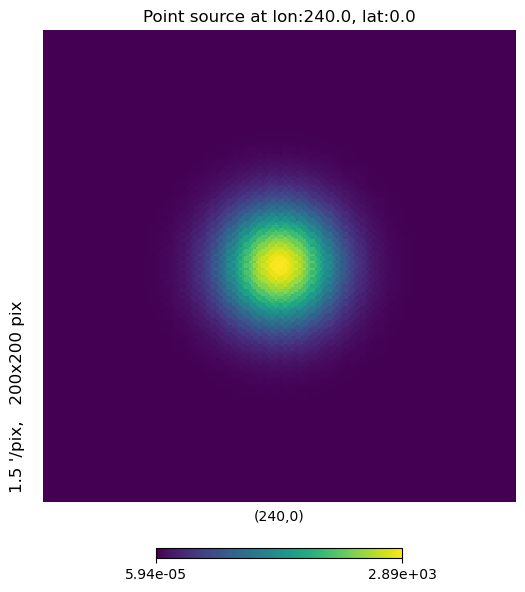

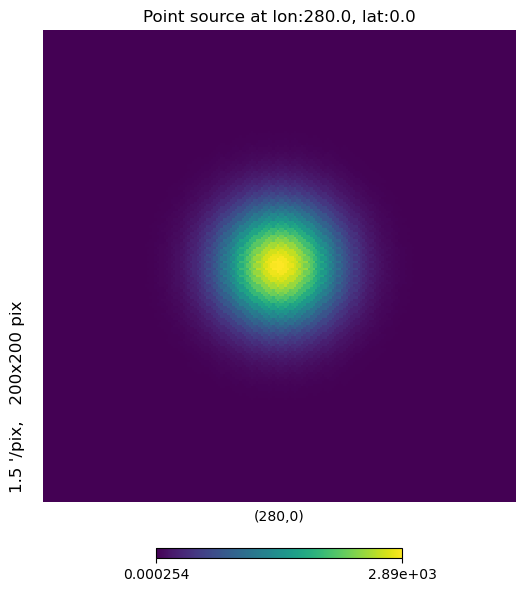

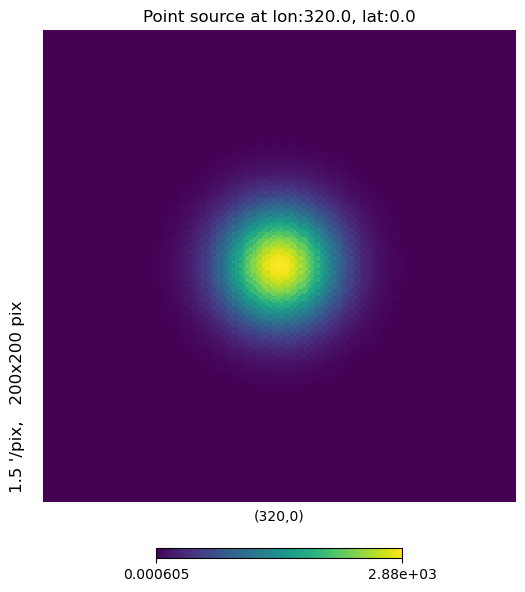

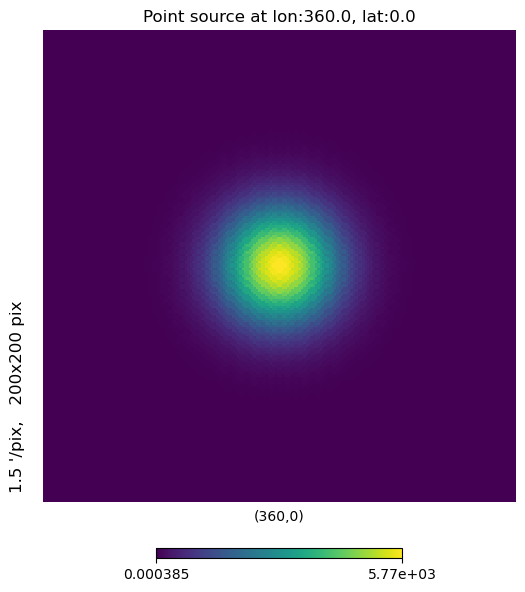

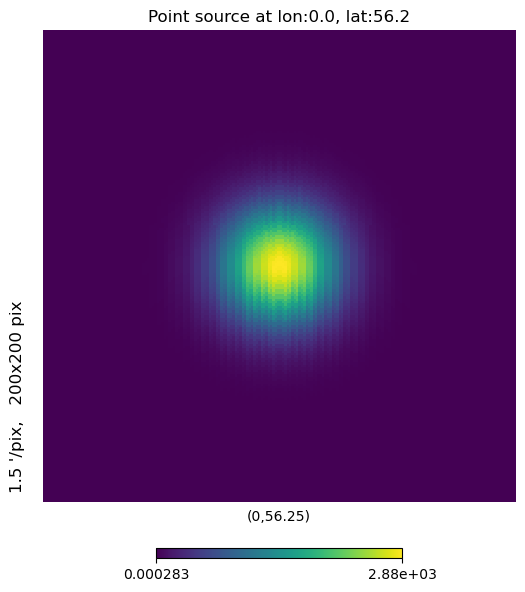

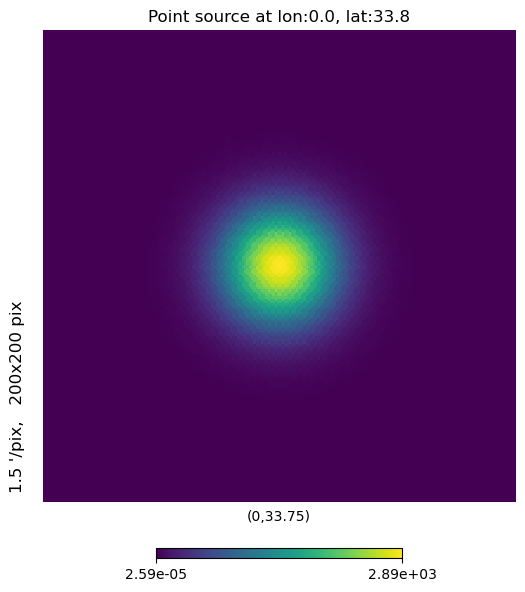

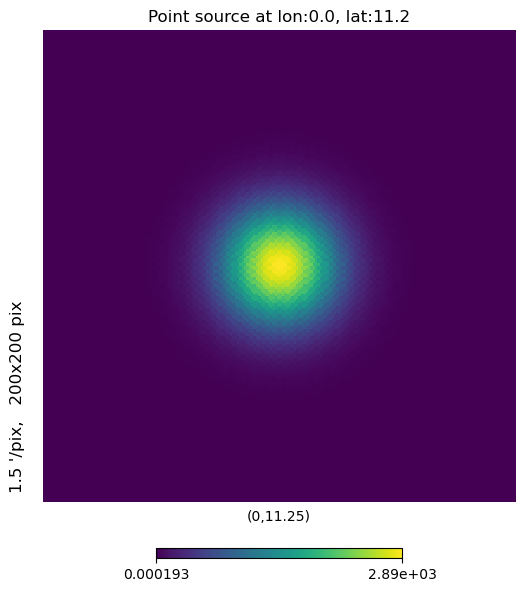

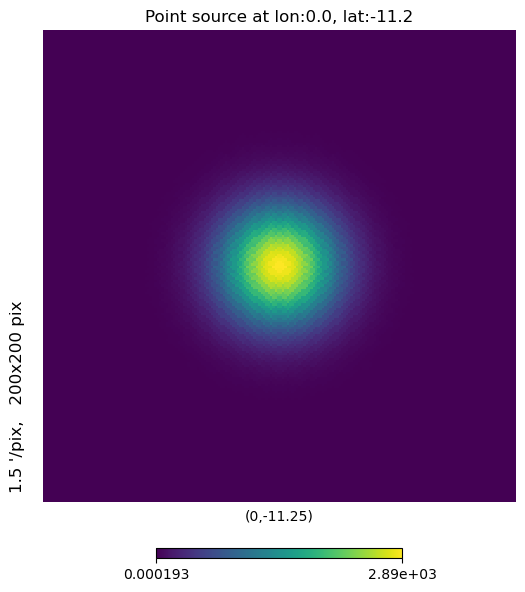

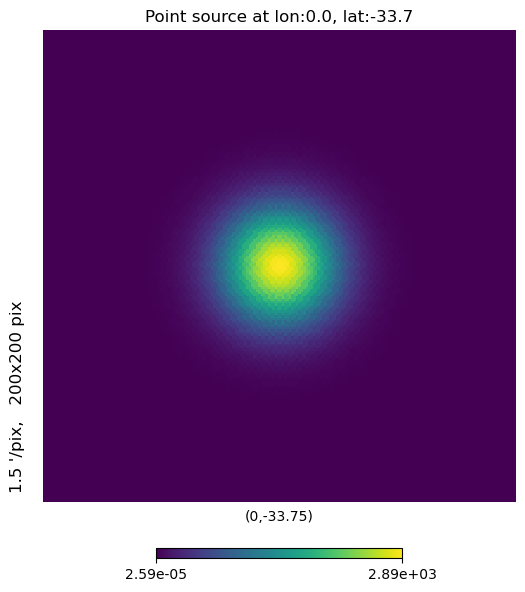

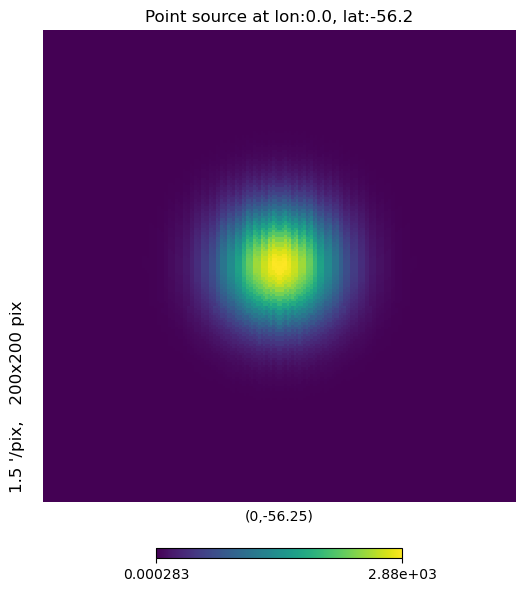

In [7]:
def thetaphi_to_lonlat(theta,phi):
    # Return longitude and latitude in degrees.
    return np.degrees(phi),90.0-np.degrees(theta)

nside = 1024
#
smoothed_map = np.abs(hp.alm2map(alms_smooth, nside))
#
for t, p in zip(thetas, phis):
    lon, lat = thetaphi_to_lonlat(t,p)
    hp.gnomview(smoothed_map, rot=[lon, lat],\
                title='Point source at lon:{:.1f}, lat:{:.1f}'.format(lon, lat))

## A single point source.

Let's look at a single source.

Sorting & digitizing took  0.3666410446166992  seconds.
Reshaping took  0.344484806060791  seconds.
Precomputing vs took  0.4769411087036133  seconds.
Computing alm's took  0.9065914154052734  seconds.


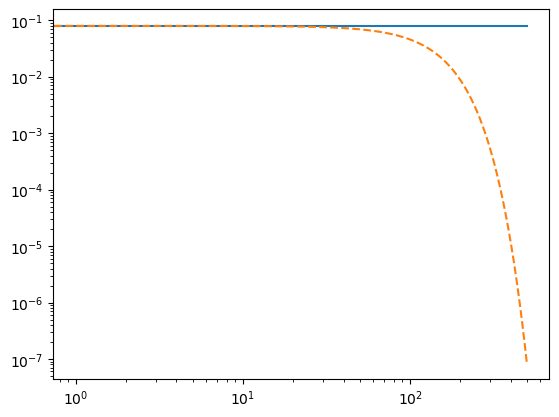

In [8]:
# Look at a single point.
phis   = np.array([np.pi/4.0])
thetas = np.ones_like(phis)*3*np.pi/8
wts    = np.ones_like(thetas)
#
alms = sht(thetas,phis,wts)
alms_smooth = hp.sphtfunc.smoothalm(alms,fwhm=np.pi/180,pol=False,inplace=False)
#
plt.loglog(hp.alm2cl(alms))
plt.loglog(hp.alm2cl(alms_smooth), ls='--')

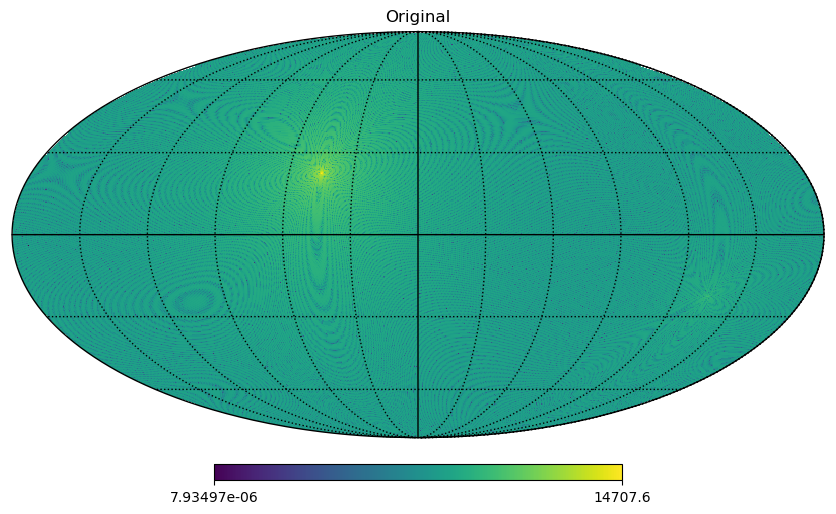

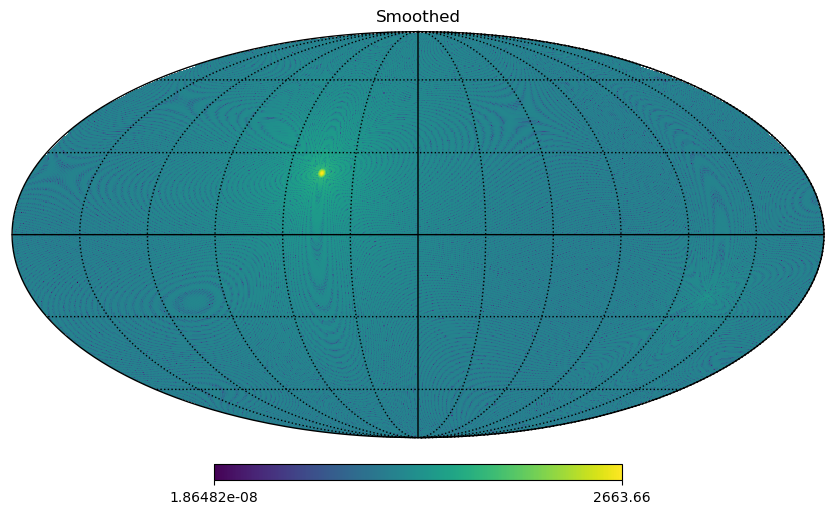

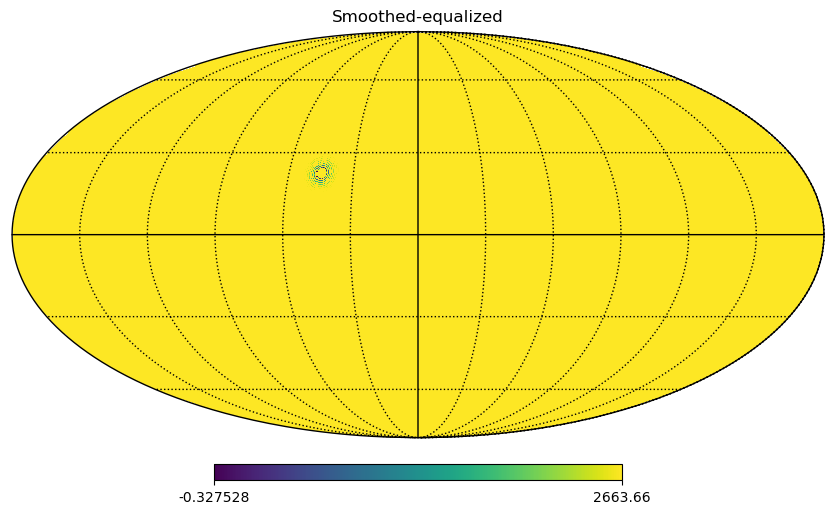

In [9]:
nside = 512
#
hp.mollview(np.abs(hp.alm2map(alms, nside)),norm='log', title='Original')
hp.graticule()
plt.show()
hp.mollview(np.abs(hp.alm2map(alms_smooth, nside)),norm='log', title='Smoothed')
hp.graticule()
plt.show()
hp.mollview(hp.alm2map(alms_smooth, nside),norm='hist', title='Smoothed-equalized')
hp.graticule()
plt.show()

And again, let's project around the source location

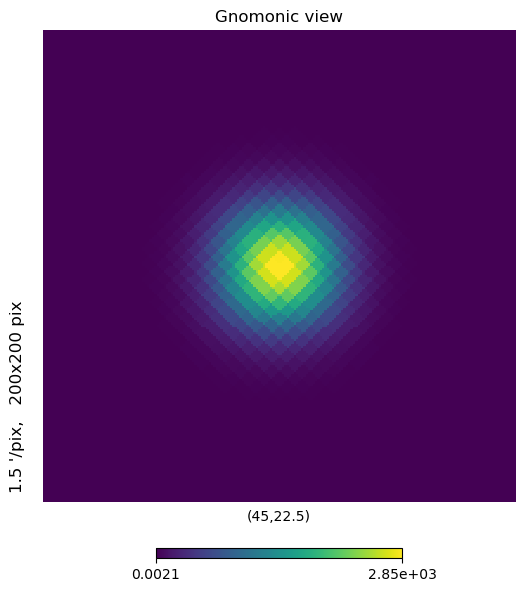

In [10]:
for t, p in zip(thetas, phis):
    lon, lat = thetaphi_to_lonlat(t,p)
    hp.gnomview(np.abs(hp.alm2map(alms_smooth, nside)), rot=[lon, lat])

## Sampling from a uniform density.

In [11]:
rng = np.random.default_rng()

Sorting & digitizing took  1.2803001403808594  seconds.
Reshaping took  0.8346726894378662  seconds.
Precomputing vs took  1.1621277332305908  seconds.
Computing alm's took  1.5613958835601807  seconds.
Sorting & digitizing took  1.2488117218017578  seconds.
Reshaping took  0.6825857162475586  seconds.
Precomputing vs took  1.0145361423492432  seconds.
Computing alm's took  1.0810790061950684  seconds.


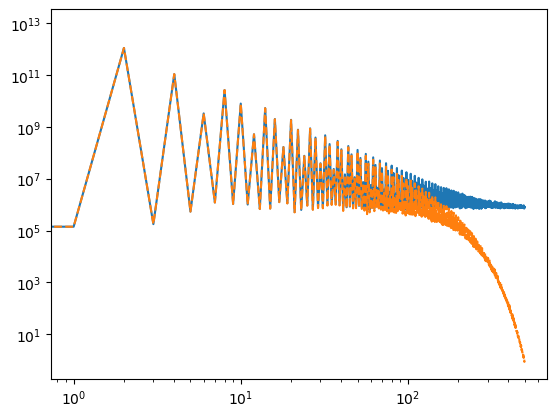

In [12]:
# Look at points drawn at random from a uniform density
# between DEC=-30 and DEC=+30.
Npnt      = int(1e7)
cmin,cmax = np.sin(np.radians(-30)),np.sin(np.radians(30.))
theta     = np.arccos(rng.uniform(low=cmin,high=cmax,size=Npnt))
phi       = rng.uniform(low=0.0,high=2*np.pi,size=Npnt)
wt        = np.ones(Npnt)
#
alms = sht(theta,phi,wt)
alms_smooth = hp.sphtfunc.smoothalm(alms,fwhm=np.pi/180,pol=False,inplace=False)
#
plt.loglog(hp.alm2cl(alms))
plt.loglog(hp.alm2cl(alms_smooth), ls='--')

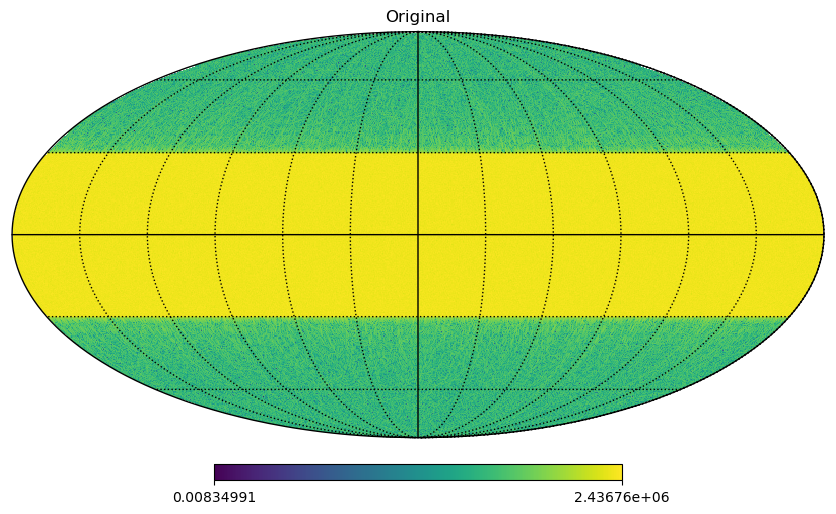

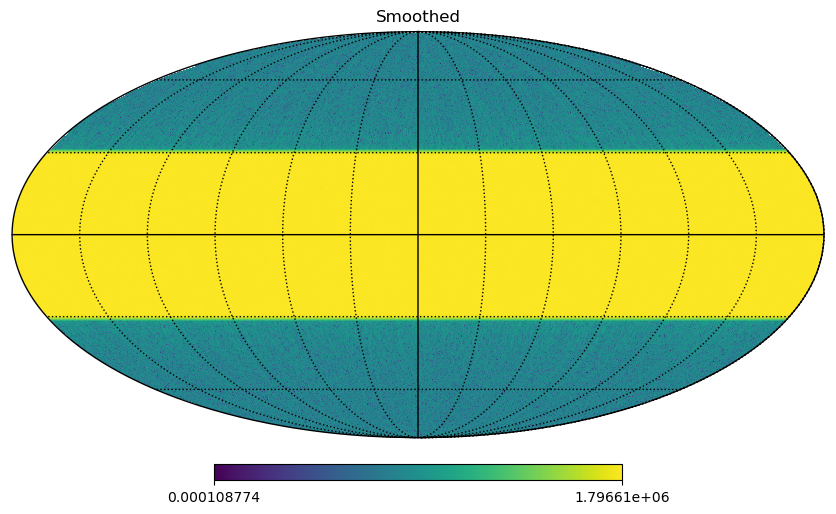

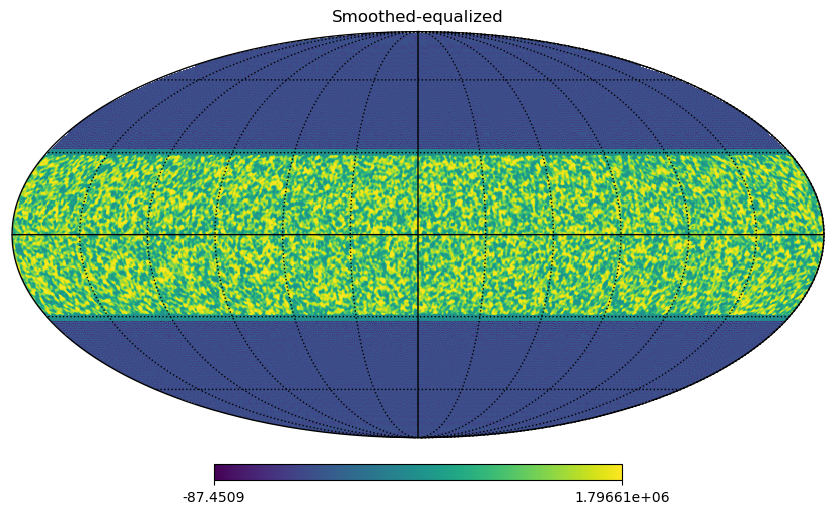

In [13]:
nside = 512
#
hp.mollview(np.abs(hp.alm2map(alms, nside)),norm='log', title='Original')
hp.graticule()
plt.show()
hp.mollview(np.abs(hp.alm2map(alms_smooth, nside)),norm='log', title='Smoothed')
hp.graticule()
plt.show()
hp.mollview(hp.alm2map(alms_smooth, nside),norm='hist', title='Smoothed-equalized')
hp.graticule()
plt.show()

# Spectral shaping

We can also do "harmonic space apodization", i.e. apply a filter to the $a_{\ell m}$ before generating a map from them.  This is another way to do "higher order charge assignment" and turn our field into a band-limited function where we know **exactly** what we've done in harmonic space.  So the equivalent window function is perfectly known (since we applied it!).

In [14]:
# Look at a single point.
phis   = np.array([np.pi/4.0])
thetas = np.ones_like(phis)*3*np.pi/8
wts    = np.ones_like(thetas)
#
Nl,Nx  = 1000,1000
sht    = DirectSHT(Nl,Nx)
alms   = sht(thetas,phis,wts)

Sorting & digitizing took  0.0018770694732666016  seconds.
Reshaping took  0.02018117904663086  seconds.
Precomputing vs took  0.2135603427886963  seconds.
Computing alm's took  1.6303822994232178  seconds.


In [15]:
# Use a simple cosine apodization.
lmin,lmax = sht.Nell//2,sht.Nell
ells      = np.arange(sht.Nell)
beamwindow= np.cos( 0.5*np.pi*(ells-lmin)/(lmax-lmin) )
beamwindow[:lmin] = 1.0
#
alms_apod = hp.sphtfunc.smoothalm(alms,beam_window=beamwindow,pol=False,inplace=False)

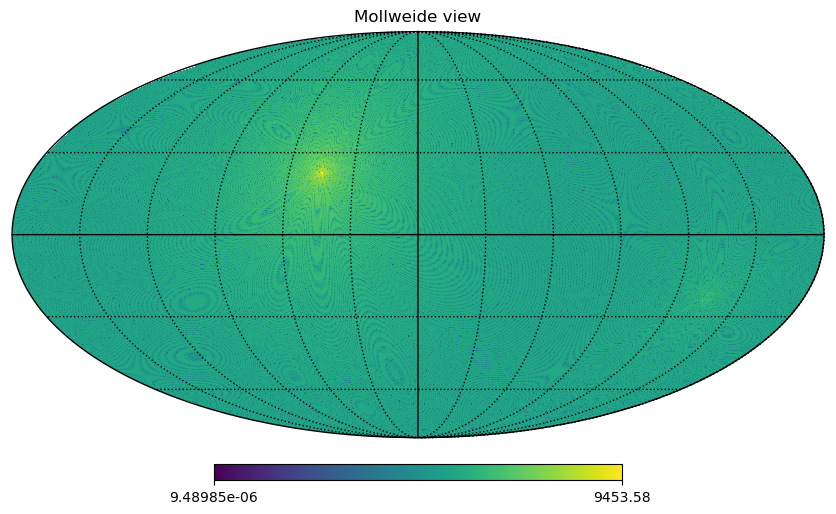

In [16]:
nside = 1024
#
hp.mollview(np.abs(hp.alm2map(alms,nside)),norm='log')
hp.graticule()
plt.show()

# The End